**Task 1:**

Genre column includes multiple genres related to that movie. Build a bag of words representation of Genre column for each row.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
movies_df = pd.read_csv("IMDB-Movie-Data.csv") # load dataset
movies_df.head(3) # visualize first 3 rows

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0


In [ ]:
movies_df.columns # vizualize column names

Index(['Rank', 'Title', 'Genre', 'Description', 'Director', 'Actors', 'Year',
       'Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)',
       'Metascore'],
      dtype='object')

In [ ]:
movies_df = movies_df.drop(['Rank', 'Description', 'Year'],axis=1) # remove unnecessary columns / the columns that we do not need 

In [ ]:
movies_df = movies_df.dropna() # remove missing (e.g. NaN) values from dataframe

In [ ]:
genre_list = movies_df.Genre.values.tolist() # get genre column in a list

In [ ]:
genre_unique_names = movies_df.Genre.str.split(",").explode().unique().tolist() # get a list of all different unique genres in dataframe
genre_unique_names

['Action',
 'Adventure',
 'Sci-Fi',
 'Mystery',
 'Horror',
 'Thriller',
 'Animation',
 'Comedy',
 'Family',
 'Fantasy',
 'Drama',
 'Music',
 'Biography',
 'Romance',
 'History',
 'Western',
 'Crime',
 'War',
 'Musical',
 'Sport']

In [ ]:
# create a new dataframe including Title (only for ease of reading) and unique genres columns
bow_df = pd.DataFrame(columns = ['Title'] + genre_unique_names) 

In [ ]:
# for each movie(row), considering movie's genre(s) (taken from genre_list),
# put 1 to the existing genre's column value for that movie, otherwise 0.
for i in range(0,movies_df.shape[0]):
  new_list = [movies_df.iloc[i,0]] + len(genre_unique_names)*[0] # create an initial empty row for current movie
  current_genres = genre_list[i].replace("'", "").split(",") # get a list of that movie's genre(s)
  for element in current_genres: # for each genre of that movie
    new_list[genre_unique_names.index(element)+1] = 1 # change related column value with 1
  bow_df.loc[i] = new_list # update bow_df
bow_df.head(3) # vizualize first 3 rows of bow_df (bag of words dataframe)

,Title,Action,Adventure,Sci-Fi,Mystery,Horror,Thriller,Animation,Comedy,Family,Fantasy,Drama,Music,Biography,Romance,History,Western,Crime,War,Musical,Sport
0,Guardians of the Galaxy,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Prometheus,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Split,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Task 2 and Task 3:**

Using this new feature and some others try to understand whether the movie is GOOD or BAD. Good movie is if rating is greater and equal to 8, otherwise the movie is BAD. Calculate the precision and recall of your model.

In [ ]:
# for a given rating x, it returns 1 if x is greater and equal to 8, otherwise it is 0
def rating_function(x):
  if x >= 8.0: return 1
  else: return 0

In [ ]:
# add useful features to our bag of words dataframe
bow_df["Votes"] = movies_df["Votes"] # add Votes column to bow_df because Votes should be related with Ranking
bow_df["Revenue (Millions)"] = movies_df["Revenue (Millions)"]  # add Revenue (Millions) column to bow_df because it shows how this movie is preferred
bow_df["Metascore"] = movies_df["Metascore"]  # add Metascore column to bow_df because it gives an additional score information about data which is related with Ranking

In [ ]:
bow_df["Rating_category"] = movies_df.Rating.apply(rating_function) # add a Rating_category column with 0 and 1 values using rating_function

In [ ]:
bow_df.head(3) # vizualize first 3 rows of current bow_df

,Title,Action,Adventure,Sci-Fi,Mystery,Horror,Thriller,Animation,Comedy,Family,Fantasy,Drama,Music,Biography,Romance,History,Western,Crime,War,Musical,Sport,Votes,Revenue (Millions),Metascore,Rating_category
0,Guardians of the Galaxy,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,757074.0,333.13,76.0,1.0
1,Prometheus,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,485820.0,126.46,65.0,0.0
2,Split,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,157606.0,138.12,62.0,0.0


In [ ]:
# The range of columns (Votes, Revenues, Metascore and Genres) vary too much. Therefore, we apply a normalization to make 0-1 range all columns
# This will help with the machine learning (otherwise, e.g. algorithm can focus more to Votes and not care about genres)
df_min_max_scaled = movies_df.copy()
bow_df['Votes'] = (df_min_max_scaled['Votes'] - df_min_max_scaled['Votes'].min()) / (df_min_max_scaled['Votes'].max() - df_min_max_scaled['Votes'].min())    
bow_df['Revenue (Millions)'] = (df_min_max_scaled['Revenue (Millions)'] - df_min_max_scaled['Revenue (Millions)'].min()) / (df_min_max_scaled['Revenue (Millions)'].max() - df_min_max_scaled['Revenue (Millions)'].min())    
bow_df['Metascore'] = (df_min_max_scaled['Metascore'] - df_min_max_scaled['Metascore'].min()) / (df_min_max_scaled['Metascore'].max() - df_min_max_scaled['Metascore'].min())    
bow_df.head(3) # vizualize first 3 rows of normalized bow_df

,Title,Action,Adventure,Sci-Fi,Mystery,Horror,Thriller,Animation,Comedy,Family,Fantasy,Drama,Music,Biography,Romance,History,Western,Crime,War,Musical,Sport,Votes,Revenue (Millions),Metascore,Rating_category
0,Guardians of the Galaxy,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.422437,0.355669,0.730337,1.0
1,Prometheus,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.271045,0.135016,0.606742,0.0
2,Split,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.087863,0.147465,0.573034,0.0


In [ ]:
bow_df = bow_df.dropna() # Remove NaN values from current dataframe (otherwise, they will generate error during training)

In [ ]:
# create variables
X = bow_df[['Action', 'Adventure', 'Sci-Fi', 'Mystery', 'Horror', 'Thriller', 'Animation', 'Comedy', 'Family', 'Fantasy', 'Drama', 'Music', 'Biography',
        'Romance', 'History', 'Crime', 'Western', 'War', 'Musical', 'Sport', 'Votes', 'Revenue (Millions)', 'Metascore']] # get input columns (we did not take Title)
y = bow_df['Rating_category'] # get target column

              precision    recall  f1-score   support

     good: 1       0.92      0.97      0.94        61
      bad: 0       0.75      0.55      0.63        11

    accuracy                           0.90        72
   macro avg       0.84      0.76      0.79        72
weighted avg       0.90      0.90      0.90        72



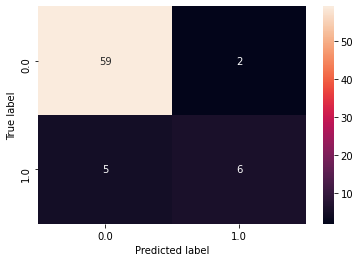

In [ ]:
# Classification - Binary classification between good (1) and bad (0) movies
# Use of train test split (I also tried with 5 and 10 fold crossvalidation)
# Use of decision tree classifier for binary classification (I also used logistic regression, svm and some other classifiers)
# I reported best results (without overfitting)
# 0 is used for BAD - 1 is used for GOOD 

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42)

parameters_dt = {'max_depth':range(10,20)}
clf_dt = GridSearchCV(DecisionTreeClassifier(), parameters_dt) # Apply gridsearch to find the best parameters/fine-tune the model

clf_dt.fit(X_train, y_train) # fit the training data to the model
y_pred_dt = clf_dt.best_estimator_.predict(X_test) # give test data and get predicted target values (1 or 0 = good or bad)

# By using predicted y values and the real y values we calculate performance metrics.
# For ease of reading, we also give a heatmap
confusion_matrix_dt = pd.crosstab(y_test, y_pred_dt, rownames=['True label'], colnames=['Predicted label'])
sn.heatmap(confusion_matrix_dt, annot=True)
print(classification_report(y_test, y_pred_dt, target_names=['good: 1','bad: 0']))
plt.show()